**Import Library**

In [18]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import roc_auc_score, roc_curve


**Load Data**

In [4]:
app = pd.read_csv('/content/application_train.csv')
bureau = pd.read_csv('/content/bureau.csv')
bureau_balance = pd.read_csv('/content/bureau_balance.csv')
prev = pd.read_csv('/content/previous_application.csv')
pos = pd.read_csv('/content/POS_CASH_balance.csv')
cc = pd.read_csv('/content/credit_card_balance.csv')
install = pd.read_csv('/content/installments_payments.csv')


**Feature Engineering**



*   Bureau




In [5]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'sum',
    'DAYS_CREDIT': 'mean'
}).reset_index()

bureau_agg.columns = [
    'SK_ID_CURR',
    'BUREAU_CREDIT_SUM',
    'BUREAU_DEBT_SUM',
    'BUREAU_OVERDUE_SUM',
    'BUREAU_DAYS_CREDIT_MEAN'
]




*   Bureau Balance



In [6]:
bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': 'min'
}).reset_index()

bureau = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')

bb_final = bureau.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'mean'
}).reset_index()

bb_final.columns = ['SK_ID_CURR', 'BUREAU_MONTHS_BALANCE_MEAN']




*   Previous Application



In [7]:
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': 'mean',
    'AMT_CREDIT': 'mean',
    'CNT_PAYMENT': 'mean'
}).reset_index()

prev_agg.columns = [
    'SK_ID_CURR',
    'PREV_APP_AMT_APPLICATION_MEAN',
    'PREV_APP_AMT_CREDIT_MEAN',
    'PREV_APP_CNT_PAYMENT_MEAN'
]




*   Pos Cash Balance



In [8]:
pos_agg = pos.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'min',
    'SK_DPD': 'mean',
    'SK_DPD_DEF': 'mean'
}).reset_index()

pos_agg.columns = [
    'SK_ID_CURR',
    'POS_MONTHS_BALANCE_MIN',
    'POS_DPD_MEAN',
    'POS_DPD_DEF_MEAN'
]




*   Credit Card Balance



In [9]:
cc_agg = cc.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'SK_DPD': 'mean'
}).reset_index()

cc_agg.columns = [
    'SK_ID_CURR',
    'CC_BALANCE_MEAN',
    'CC_LIMIT_MEAN',
    'CC_DPD_MEAN'
]




*   Installaments Payments



In [10]:
install['PAYMENT_DIFF'] = install['AMT_PAYMENT'] - install['AMT_INSTALMENT']
install['DAYS_LATE'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

install_agg = install.groupby('SK_ID_CURR').agg({
    'PAYMENT_DIFF': 'mean',
    'DAYS_LATE': 'mean'
}).reset_index()

install_agg.columns = [
    'SK_ID_CURR',
    'INST_PAYMENT_DIFF_MEAN',
    'INST_DAYS_LATE_MEAN'
]


**Marge Ke Apllication Train**

In [11]:
df = app.merge(bureau_agg, on='SK_ID_CURR', how='left')
df = df.merge(bb_final, on='SK_ID_CURR', how='left')
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')
df = df.merge(pos_agg, on='SK_ID_CURR', how='left')
df = df.merge(cc_agg, on='SK_ID_CURR', how='left')
df = df.merge(install_agg, on='SK_ID_CURR', how='left')


**Preprocessing**

In [12]:
X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df['TARGET']

# hanya numeric
X = X.select_dtypes(include=['number'])

# missing value
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


**Modeling**



*   Logistic Regression



In [13]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

pred_lr = lr.predict_proba(X_valid_scaled)[:,1]
auc_lr = roc_auc_score(y_valid, pred_lr)




*   Random Forest



In [14]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)
rf.fit(X_train, y_train)

pred_rf = rf.predict_proba(X_valid)[:,1]
auc_rf = roc_auc_score(y_valid, pred_rf)




*   XGBoost



In [15]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc'
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict_proba(X_valid)[:,1]
auc_xgb = roc_auc_score(y_valid, pred_xgb)


**Tabel Hasil**

In [16]:
result_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC AUC': [auc_lr, auc_rf, auc_xgb]
})

result_df


,Model,ROC AUC
0,Logistic Regression,0.744302
1,Random Forest,0.745079
2,XGBoost,0.767264


**Grafik Roc Curve**

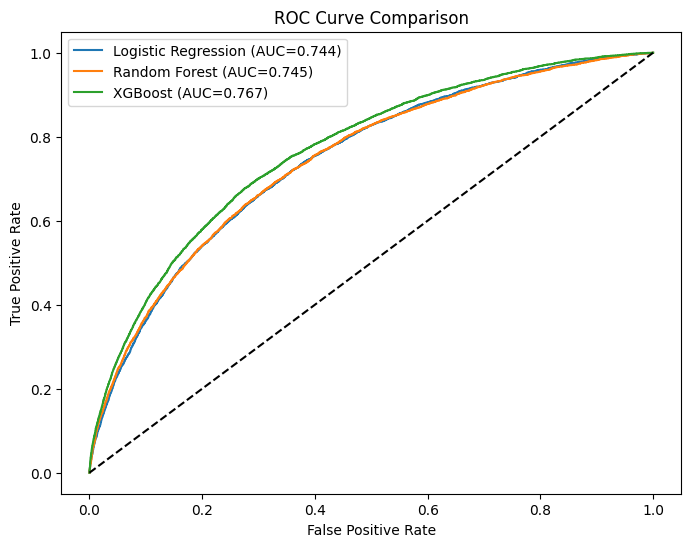

In [17]:
plt.figure(figsize=(8,6))

fpr, tpr, _ = roc_curve(y_valid, pred_lr)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC={auc_lr:.3f})')

fpr, tpr, _ = roc_curve(y_valid, pred_rf)
plt.plot(fpr, tpr, label=f'Random Forest (AUC={auc_rf:.3f})')

fpr, tpr, _ = roc_curve(y_valid, pred_xgb)
plt.plot(fpr, tpr, label=f'XGBoost (AUC={auc_xgb:.3f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


***Prediksi Target (0/1) Dari XGBoost***

In [19]:
# Threshold standar
threshold = 0.5

# Probabilitas gagal bayar
df_valid = df.loc[y_valid.index].copy()
df_valid['PROBA_DEFAULT'] = pred_xgb

# Prediksi final TARGET
df_valid['PREDICTED_TARGET'] = (df_valid['PROBA_DEFAULT'] >= threshold).astype(int)

df_valid[['SK_ID_CURR', 'PROBA_DEFAULT', 'PREDICTED_TARGET', 'TARGET']].head()


,SK_ID_CURR,PROBA_DEFAULT,PREDICTED_TARGET,TARGET
245895,384575,0.112954,0,0
98194,214010,0.020346,0,0
36463,142232,0.102585,0,0
249923,389171,0.031283,0,0
158389,283617,0.023622,0,0


***Tabel Nasabah Berisiko Tinggi***

In [20]:
high_risk = df_valid[df_valid['PREDICTED_TARGET'] == 1] \
    .sort_values('PROBA_DEFAULT', ascending=False)

high_risk[['SK_ID_CURR', 'PROBA_DEFAULT', 'TARGET']].head(10)


,SK_ID_CURR,PROBA_DEFAULT,TARGET
227635,363674,0.885917,1
29543,134303,0.876288,1
234374,371490,0.827049,1
191920,322543,0.807495,1
272229,415612,0.805075,1
256959,397357,0.798082,0
209776,343112,0.796070,1
20233,123605,0.789358,1
25632,129807,0.786284,0
129565,250277,0.773563,1


from matplotlib import pyplot as plt
_df_0['SK_ID_CURR'].plot(kind='hist', bins=20, title='SK_ID_CURR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['PROBA_DEFAULT'].plot(kind='hist', bins=20, title='PROBA_DEFAULT')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['TARGET'].plot(kind='hist', bins=20, title='TARGET')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='SK_ID_CURR', y='PROBA_DEFAULT', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='PROBA_DEFAULT', y='TARGET', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['SK_ID_CURR'].plot(kind='line', figsize=(8, 4), title='SK_ID_CURR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['PROBA_DEFAULT'].plot(kind='line', figsize=(8, 4), title='PROBA_DEFAULT')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['TARGET'].plot(kind='line', figsize=(8, 4), title='TARGET')
plt.gca().spines[['top', 'right']].set_visible(False)

***Confusion Matrix***

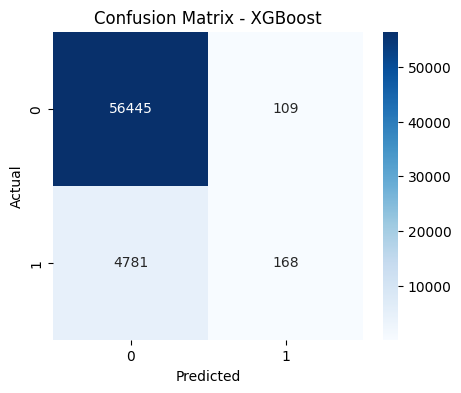

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_valid, df_valid['PREDICTED_TARGET'])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()


***Classification Report***

In [22]:
print(classification_report(
    y_valid,
    df_valid['PREDICTED_TARGET'],
    target_names=['Non-Default (0)', 'Default (1)']
))


                 precision    recall  f1-score   support

Non-Default (0)       0.92      1.00      0.96     56554
    Default (1)       0.61      0.03      0.06      4949

       accuracy                           0.92     61503
      macro avg       0.76      0.52      0.51     61503
   weighted avg       0.90      0.92      0.89     61503



***Feature Importance XGBoost***

In [23]:
importance = xgb.feature_importances_
feature_names = df.drop(['TARGET', 'SK_ID_CURR'], axis=1) \
                  .select_dtypes(include=['number']).columns

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False).head(15)

feat_imp


,Feature,Importance
29,EXT_SOURCE_3,0.063736
28,EXT_SOURCE_2,0.056004
12,FLAG_EMP_PHONE,0.028159
27,EXT_SOURCE_1,0.020608
79,FLAG_DOCUMENT_3,0.020244
19,REGION_RATING_CLIENT_W_CITY,0.016572
115,CC_BALANCE_MEAN,0.016288
114,POS_DPD_DEF_MEAN,0.014754
4,AMT_GOODS_PRICE,0.014591
6,DAYS_BIRTH,0.013087


***Visualisasi Feature Importance***

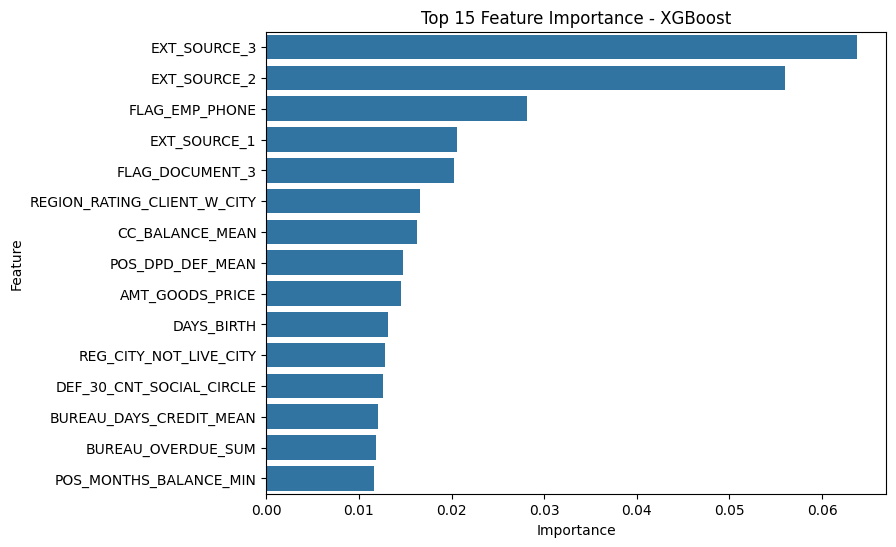

In [24]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=feat_imp,
    x='Importance',
    y='Feature'
)
plt.title('Top 15 Feature Importance - XGBoost')
plt.show()


# ***Tabel Final Business User***

In [28]:
final_output = df_valid[[
    'SK_ID_CURR',
    'PROBA_DEFAULT',
    'PREDICTED_TARGET',
    'TARGET'
]].copy()

final_output['RISK_LEVEL'] = pd.cut(
    final_output['PROBA_DEFAULT'],
    bins=[0, 0.3, 0.6, 1],
    labels=['Low', 'Medium', 'High']
)

final_output.head()


,SK_ID_CURR,PROBA_DEFAULT,PREDICTED_TARGET,TARGET,RISK_LEVEL
245895,384575,0.112954,0,0,Low
98194,214010,0.020346,0,0,Low
36463,142232,0.102585,0,0,Low
249923,389171,0.031283,0,0,Low
158389,283617,0.023622,0,0,Low


# ***PIE CHART HASIL PREDIKSI NASABAH***

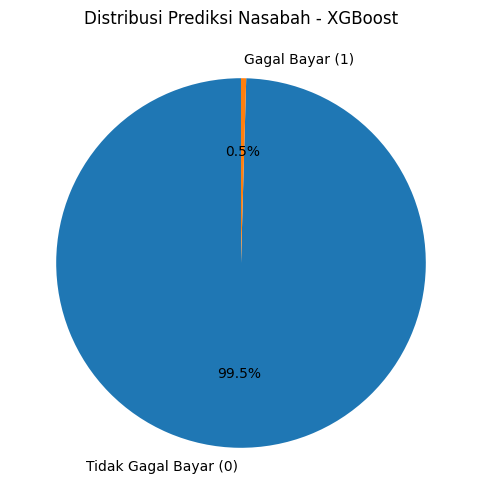

In [29]:
pred_counts = df_valid['PREDICTED_TARGET'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    pred_counts,
    labels=['Tidak Gagal Bayar (0)', 'Gagal Bayar (1)'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Distribusi Prediksi Nasabah - XGBoost')
plt.show()
